In [5]:
import numpy as np
import pandas as pd
import glob
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Code for figure 2

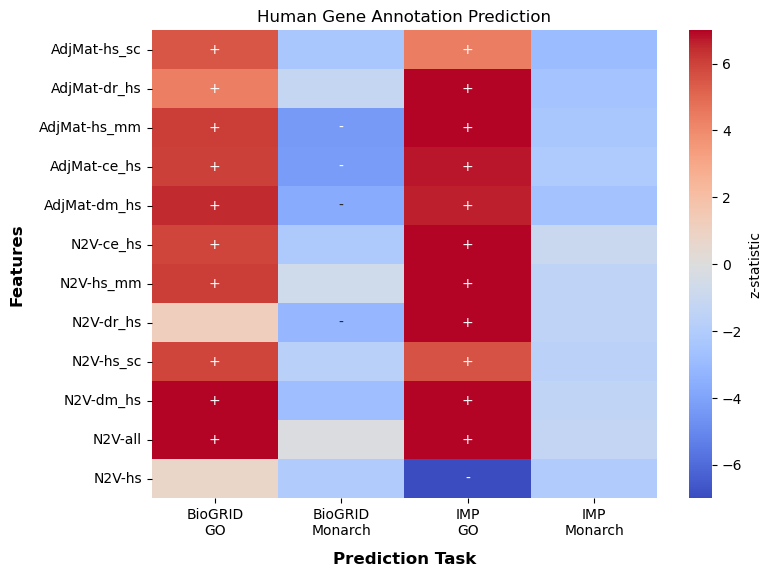

In [6]:
# %%capture --no-display

fp_data = "../results/metrics/"
FNs1 = glob.glob(fp_data+"Metric*AllOnes*adj*.tsv")
FNs2 = glob.glob(fp_data+"Metric*SummedDegree-0.50*2000*0.1_0.001_120_8_10*.tsv")
FNs3 = glob.glob(fp_data+"Metric*AllOnes*2000*0.1_0.001_120_8_10*.tsv")
FNs = FNs1 + FNs2 + FNs3
df_results = pd.DataFrame()
for aFN in FNs:
    df_tmp = pd.read_csv(aFN,sep="\t")
    if df_tmp.shape[0] == 0:
        # this is for dr BioGRID where there are no terms
        continue
    # remove hs_mm that has AllOnes embeddings
    if ("AllOnes" in aFN) and ("hs_mm" in aFN) and ("Pecanpy" in aFN):
        continue
    GSCtmp = "_".join(df_tmp["GSC_info"].to_list()[0].split("__")[1].split("_")[0:2])
    df_tmp["GSC"] = [GSCtmp] * df_tmp.shape[0]
    df_results = pd.concat([df_results,df_tmp])
df_results.head()

ylabels = ['AdjMat-hs_sc', 'AdjMat-dr_hs', 'AdjMat-hs_mm',
           'AdjMat-ce_hs', 'AdjMat-dm_hs', 'N2V-ce_hs', 'N2V-hs_mm',
           'N2V-dr_hs', 'N2V-hs_sc', 'N2V-dm_hs', 'N2V-all', 'N2V-hs']
xlabels = ["BioGRID\nGO","BioGRID\nMonarch","IMP\nGO","IMP\nMonarch"]

z_scores_all = []
p_values_all = []
# Stats for figure 2
for idx2, anet in enumerate(["BioGRID_raw","IMP_raw"]):
    for idx1, aGSC in enumerate(["GO", "Monarch"]):
        df_tmp = df_results[(df_results["network"]==anet)&
                            (df_results["GSC"]==f"{aGSC}_hs")]
        features_tmp = df_tmp["feature_type"].to_list()
        species_tmp = df_tmp["species"].to_list()
        features_new = []
        for idx, afeat in enumerate(features_tmp):
            if afeat == "adj":
                features_new.append(f"AdjMat-{species_tmp[idx]}")
            elif "Pecanpy" in afeat:
                if species_tmp[idx] == "ce_dm_dr_hs_mm_sc":
                    features_new.append(f"N2V-all")
                else:
                    features_new.append(f"N2V-{species_tmp[idx]}")
        df_tmp["feature_new"] = features_new
        base_met = df_tmp[df_tmp["feature_new"] == "AdjMat-hs"].sort_values(by=["ID"])["log2p"].to_numpy()
        z_scores = []
        p_values = []
        for afeat_set in ylabels:
            if afeat_set == "AdjMat-hs":
                continue
            tmp_met = df_tmp[df_tmp["feature_new"] == afeat_set].sort_values(by=["ID"])["log2p"].to_numpy()
            # the z-stat in the to-sided test is not implemted correctly so using z-stat from the greater test
            # the absolute values are the same between the two tests, just the greater or less test
            # have the correct sign
            res_gr = wilcoxon(tmp_met,base_met, method="approx", alternative = "greater")
            res_ts = wilcoxon(tmp_met,base_met, method="approx", alternative = "two-sided")
            z_scores.append(res_gr.zstatistic)
            if (res_ts.pvalue < 0.01/len(xlabels)) and (res_gr.zstatistic > 0):
                p_values.append("+")
            elif (res_ts.pvalue < 0.01/len(xlabels)) and (res_gr.zstatistic < 0):
                p_values.append("-")
            else:
                p_values.append(" ")
        z_scores_all.append(z_scores)
        p_values_all.append(p_values)

fig, ax, = plt.subplots(figsize=(8,6))
sns.heatmap(data=np.transpose(z_scores_all),annot=np.transpose(p_values_all),fmt="",
            cmap="coolwarm",vmin=-7,vmax=7,
            xticklabels=xlabels,yticklabels=ylabels,
            cbar_kws={'label': 'z-statistic'})
ax.set_xlabel("Prediction Task",fontweight="bold",labelpad=10,fontsize=12)
ax.set_ylabel("Features",fontweight="bold",labelpad=10,fontsize=12)
ax.set_title("Human Gene Annotation Prediction")
fig.subplots_adjust(left=0.2,bottom=0.15,right=0.99,top=0.93)
fig.savefig('../figures/FigSM5.pdf')


# Code for Figure 3

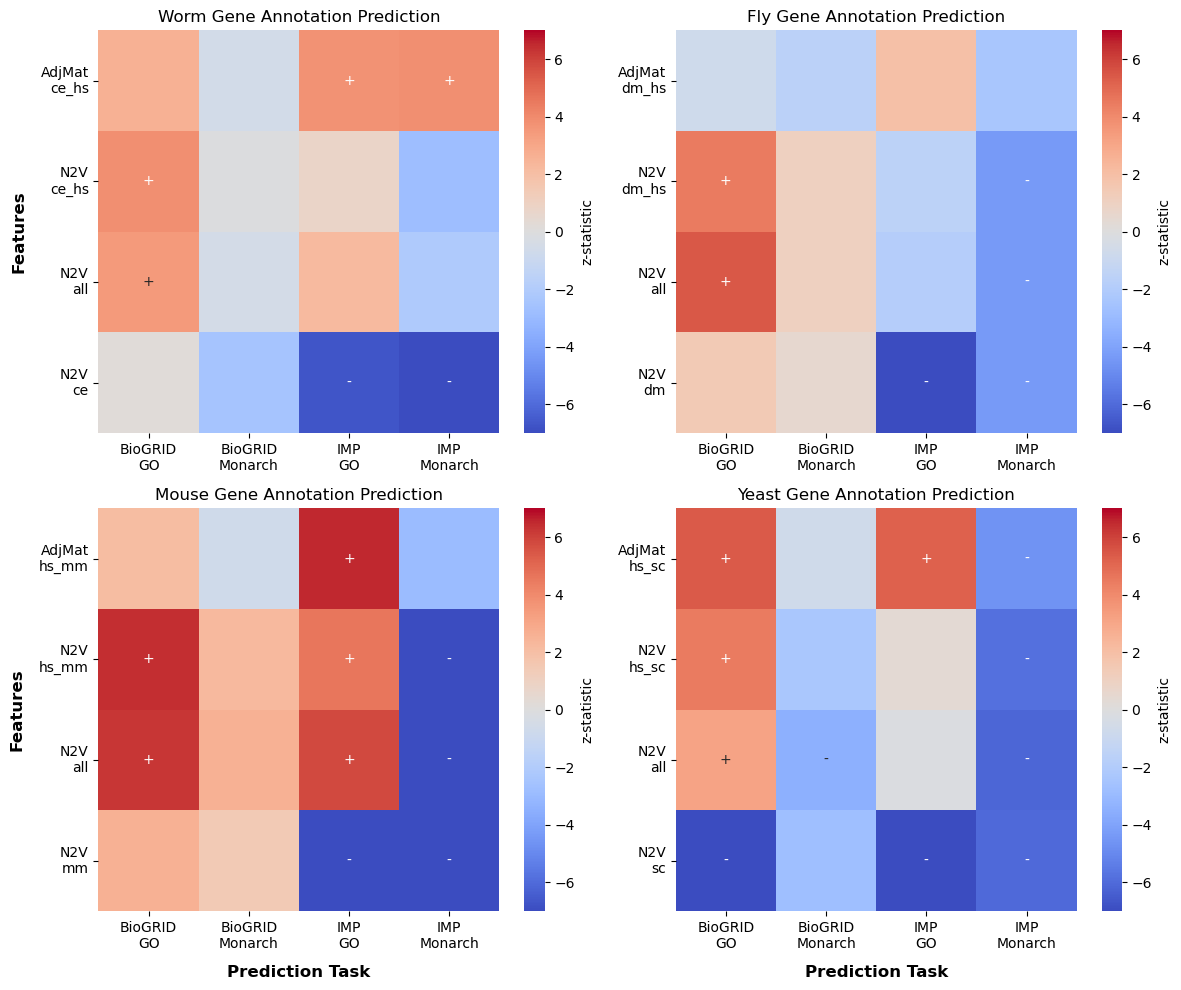

In [7]:
# %%capture --no-display

name_convert = {"hs":"Human","ce":"Worm","dm":"Fly","mm":"Mouse","sc":"Yeast"}

fp_data = "../results/metrics/"
FNs1 = glob.glob(fp_data+"Metric*AllOnes*adj*.tsv")
FNs2 = glob.glob(fp_data+"Metric*SummedDegree-0.50*2000*0.1_0.001_120_8_10*.tsv")
FNs3 = glob.glob(fp_data+"Metric*AllOnes*2000*0.1_0.001_120_8_10*.tsv")
FNs = FNs1 + FNs2 + FNs3
df_results = pd.DataFrame()
for aFN in FNs:
    df_tmp = pd.read_csv(aFN,sep="\t")
    if df_tmp.shape[0] == 0:
        # this is for dr BioGRID where there are no terms
        continue
    # remove hs_mm that has AllOnes embeddings
    if ("AllOnes" in aFN) and ("hs_mm" in aFN) and ("Pecanpy" in aFN):
        continue
    GSCtmp = "_".join(df_tmp["GSC_info"].to_list()[0].split("__")[1].split("_")[0:2])
    df_tmp["GSC"] = [GSCtmp] * df_tmp.shape[0]
    df_results = pd.concat([df_results,df_tmp])
df_results.head()

# Stats for figure 2
fig, ax = plt.subplots(2,2,figsize=(12,10))
axs = ax.ravel()
for idx_ax, sp_to_use in enumerate(["ce","dm","mm","sc"]):
    z_scores_all = []
    p_values_all = []
    for idx2, anet in enumerate(["BioGRID_raw","IMP_raw"]):
        for idx1, aGSC in enumerate(["GO", "Monarch"]):
            if sp_to_use in ["ce","dm"]:
                ylabels = [f"AdjMat\n{sp_to_use}_hs", f"N2V\n{sp_to_use}_hs",
                           f"N2V\nall", f"N2V\n{sp_to_use}"]
            elif sp_to_use in ["mm","sc"]:
                ylabels = [f"AdjMat\nhs_{sp_to_use}", f"N2V\nhs_{sp_to_use}",
                           f"N2V\nall", f"N2V\n{sp_to_use}"]
            xlabels = [f"BioGRID\nGO",f"BioGRID\nMonarch",
                       f"IMP\nGO",f"IMP\nMonarch"]
            df_tmp = df_results[(df_results["network"]==anet)&
                                (df_results["GSC"]==f"{aGSC}_{sp_to_use}")]
            features_tmp = df_tmp["feature_type"].to_list()
            species_tmp = df_tmp["species"].to_list()
            features_new = []
            for idx, afeat in enumerate(features_tmp):
                if afeat == "adj":
                    features_new.append(f"AdjMat\n{species_tmp[idx]}")
                elif "Pecanpy" in afeat:
                    if species_tmp[idx] == "ce_dm_dr_hs_mm_sc":
                        features_new.append(f"N2V\nall")
                    else:
                        features_new.append(f"N2V\n{species_tmp[idx]}")
            df_tmp["feature_new"] = features_new
            base_met = df_tmp[df_tmp["feature_new"] == f"AdjMat\n{sp_to_use}"].sort_values(by=["ID"])["log2p"].to_numpy()
            z_scores = []
            p_values = []
            for afeat_set in ylabels:
                if afeat_set == f"AdjMat\n{sp_to_use}":
                    continue
                tmp_met = df_tmp[df_tmp["feature_new"] == afeat_set].sort_values(by=["ID"])["log2p"].to_numpy()
                # the z-stat in the to-sided test is not implemted correctly so using z-stat from the greater test
                # the absolute values are the same between the two tests, just the greater or less test
                # have the correct sign
                res_gr = wilcoxon(tmp_met,base_met, method="approx", alternative = "greater")
                res_ts = wilcoxon(tmp_met,base_met, method="approx", alternative = "two-sided")
                z_scores.append(res_gr.zstatistic)
                if (res_ts.pvalue < 0.01/len(xlabels)) and (res_gr.zstatistic > 0):
                    p_values.append("+")
                elif (res_ts.pvalue < 0.01/len(xlabels)) and (res_gr.zstatistic < 0):
                    p_values.append("-")
                else:
                    p_values.append(" ")
            z_scores_all.append(z_scores)
            p_values_all.append(p_values)

    sns.heatmap(data=np.transpose(z_scores_all),annot=np.transpose(p_values_all),fmt="",
                cmap="coolwarm",vmin=-7,vmax=7,ax=axs[idx_ax],
                xticklabels=xlabels,yticklabels=ylabels,
                cbar_kws={'label': 'z-statistic'})
    axs[idx_ax].set_title(f"{name_convert[sp_to_use]} Gene Annotation Prediction")
    axs[idx_ax].set_yticklabels(ylabels, rotation=0)
    if idx_ax in [0,2]:
        axs[idx_ax].set_ylabel("Features",fontweight="bold",labelpad=10,fontsize=12)
    if idx_ax in [2,3]:
        axs[idx_ax].set_xlabel("Prediction Task",fontweight="bold",labelpad=10,fontsize=12)
fig.subplots_adjust(hspace=0.3)
plt.tight_layout()
fig.savefig('../figures/FigSM6.pdf')
        


# Code for figure 4 and SM 10-12

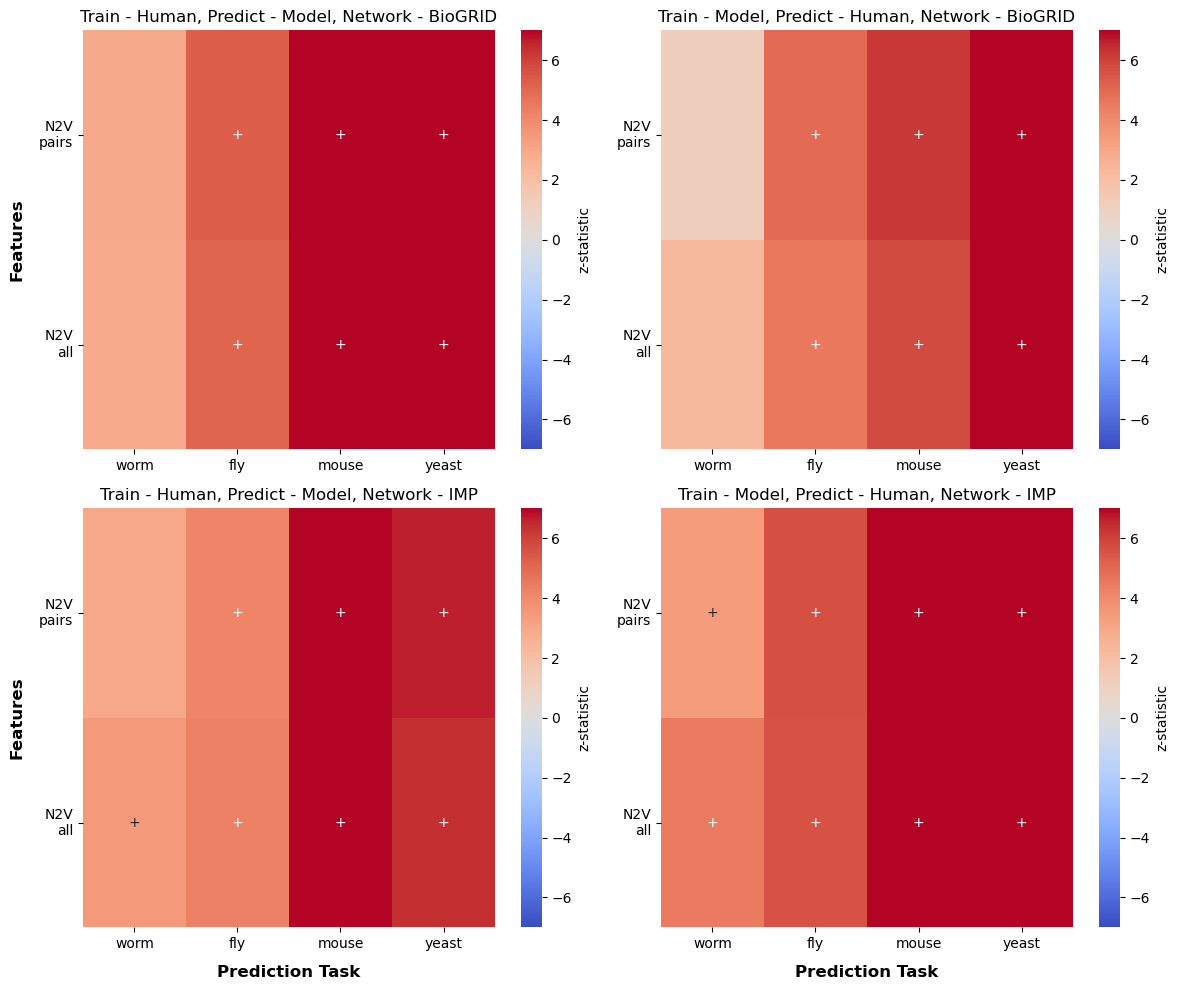

In [8]:
def get_values(data):
    values = []
    for idx in range(data.shape[0]):
        values.append(data[idx,idx])
    return values

fp_data = "../results/bothterms_weights/"

titles = ["Train - Human, Predict - Model", "Train - Model, Predict - Human"]
xlabels = ["ce", "dm", "mm", "sc"]
xlabels = ["worm", "fly", "mouse", "yeast"]
ylabels = ["N2V\npairs", "N2V\nall"]

fig, ax = plt.subplots(2,2,figsize=(12,10))
for idx_ax1, network in enumerate(["BioGRID", "IMP"]):
    for idx_ax2, task in enumerate(["log2p_hs","log2p_other"]):
        z_scores_all = []
        p_values_all = []
        for sp_info in [["ce", "ce_hs"],["dm", "dm_hs"],["mm", "hs_mm"],["sc", "hs_sc"]]:
            if task == "log2p_hs":
                data_tmp = np.load(fp_data+f"Log2P_hs_to_{sp_info[0]}__GO__{sp_info[1]}__{network}__adj.npy")
            elif task == "log2p_other":
                data_tmp = np.load(fp_data+f"Log2P_{sp_info[0]}_to_hs__GO__{sp_info[1]}__{network}__adj.npy")
            base_met = get_values(data_tmp)
            z_scores = []
            p_values = []
            for afeat in ["emb","allemb"]:
                if task == "log2p_hs":
                    data_tmp = np.load(fp_data+f"Log2P_hs_to_{sp_info[0]}__GO__{sp_info[1]}__{network}__{afeat}.npy")
                elif task == "log2p_other":
                    data_tmp = np.load(fp_data+f"Log2P_{sp_info[0]}_to_hs__GO__{sp_info[1]}__{network}__{afeat}.npy")
                tmp_met = get_values(data_tmp)
                res_gr = wilcoxon(tmp_met,base_met, method="approx", alternative = "greater")
                res_ts = wilcoxon(tmp_met,base_met, method="approx", alternative = "two-sided")
                z_scores.append(res_gr.zstatistic)
                if (res_ts.pvalue < 0.01/len(xlabels)) and (res_gr.zstatistic > 0):
                    p_values.append("+")
                elif (res_ts.pvalue < 0.01/len(xlabels)) and (res_gr.zstatistic < 0):
                    p_values.append("-")
                else:
                    p_values.append(" ")
            z_scores_all.append(z_scores)
            p_values_all.append(p_values)
            
        sns.heatmap(data=np.transpose(z_scores_all),annot=np.transpose(p_values_all),fmt="",
                    cmap="coolwarm",vmin=-7,vmax=7,ax=ax[idx_ax1,idx_ax2],
                    xticklabels=xlabels,yticklabels=ylabels,
                    cbar_kws={'label': 'z-statistic'})
        ax[idx_ax1,idx_ax2].set_title(f"{titles[idx_ax2]}, Network - {network}")
        ax[idx_ax1,idx_ax2].set_yticklabels(ylabels, rotation=0)
ax[0,0].set_ylabel("Features",fontweight="bold",labelpad=10,fontsize=12)
ax[1,0].set_ylabel("Features",fontweight="bold",labelpad=10,fontsize=12)
ax[1,0].set_xlabel("Prediction Task",fontweight="bold",labelpad=10,fontsize=12)
ax[1,1].set_xlabel("Prediction Task",fontweight="bold",labelpad=10,fontsize=12)
plt.tight_layout()
fig.savefig('../figures/FigSM7.pdf')